In [93]:
import logging
import time

from IPython.core.display_functions import clear_output
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC

# Setup logging
logging.basicConfig(filename='quantum_embedding.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

In [94]:

def quantum_encoder(theta, n, m):
    qc = QuantumCircuit(n + m)
    for i in range(n):
        qc.ry(theta[i % len(theta)], i)
    return qc

def matrix_inverse_evolution(qc, beta, adj_matrix, n, t=1):
    identity = np.eye(2**n)
    I_minus_betaA = identity - beta * adj_matrix
    
    for _ in range(t):
        for i in range(2**n):
            for j in range(2**n):
                if I_minus_betaA[i][j] != 0:
                    angle = -2 * I_minus_betaA[i][j]
                    qc.rz(angle, j % n)
    return qc

def hadamard_test(theta, beta, adj_matrix, n, m, t=1):
    qc = QuantumCircuit(1 + n + m, 1)  # 1 ancilla qubit + address and embedding registers, 1 classical bit
    
    # Prepare the initial state
    qc.h(0)  # Hadamard on the ancilla qubit
    
    # Quantum encoder circuit
    encoder_qc = quantum_encoder(theta, n, m)
    qc = qc.compose(encoder_qc, qubits=range(1, n + m + 1))
    
    # Apply controlled-U (matrix-inverse evolution)
    controlled_U = QuantumCircuit(n + m)
    controlled_U = matrix_inverse_evolution(controlled_U, beta, adj_matrix, n, t)
    qc = qc.compose(controlled_U.control(1), qubits=[0] + list(range(1, n + m + 1)))
    
    # Apply the second Hadamard gate
    qc.h(0)
    
    # Measure only the ancilla qubit
    qc.measure(0, 0)
    
    return qc

def estimate_L(theta, adj_matrix, beta, n, m, t):
    qc = hadamard_test(theta, beta, adj_matrix, n, m, t)
    logging.info(f"Quantum Circuit:\n{qc}")
    simulator = AerSimulator()
    transpiled_qc = transpile(qc, simulator)
    # display(transpiled_qc.draw())
    qobj = assemble(transpiled_qc)
    result = simulator.run(qobj).result()
    counts = result.get_counts()
    
    # Calculate expectation value <psi|U|psi>
    logging.info(f"Counts: {counts}")
    expectation_value = (counts.get('0', 0) - counts.get('1', 0)) / sum(counts.values())
    return expectation_value

In [95]:
def optimize_parameters(theta, adj_matrix, beta, alpha, delta_theta, n, m, t, max_iter=100):
    objective_values = []
    for iteration in range(max_iter):
        grad = np.zeros_like(theta)
        for i in range(len(theta)):
            theta_plus = theta.copy()
            theta_minus = theta.copy()
            theta_plus[i] += delta_theta
            theta_minus[i] -= delta_theta
            L_plus = estimate_L(theta_plus, adj_matrix, beta, n, m, t)
            # print("L_plus", L_plus)
            L_minus = estimate_L(theta_minus, adj_matrix, beta, n, m, t)
            # print("L_minus", L_minus)
            grad[i] = (L_plus - L_minus) / (2 * delta_theta)
        
        theta += alpha * grad
        L_theta = estimate_L(theta, adj_matrix, beta, n, m, t)
        objective_values.append(L_theta)
        
        # Logging information
        logging.info(f"Iteration {iteration + 1}: Objective Value = {L_theta}")
        logging.info(f"Iteration {iteration + 1}: Gradients = {grad}")
        logging.info(f"Iteration {iteration + 1}: Parameters (theta) = {theta}")

        # print(np.linalg.norm(grad)) # this is 0.0 :(
        grad_norm = np.linalg.norm(grad)
        if grad_norm < 1e-6:
            logging.info(f"Convergence reached at iteration {iteration + 1}")
            print(f"Gradient Norm: {grad_norm:.6f} < {1e-6:.6f} !!!")
            break
        print(f"Gradient Norm: {grad_norm:.6f} > {1e-6:.6f}")
    return theta, objective_values

In [96]:
def check_convergence_criterion(adj_matrix, beta):
    eigenvalues = np.linalg.eigvals(beta * adj_matrix)
    if np.max(np.abs(eigenvalues)) >= 1:
        raise ValueError("Convergence criterion is not satisfied.")
    
def check_adjacency_matrix_dimension(adj_matrix):
    if adj_matrix.shape[0] != adj_matrix.shape[1]:
        raise ValueError("Adjacency matrix must be square.")
    if adj_matrix.shape[0] < 2:
        raise ValueError("Adjacency matrix must be at least 2x2.")
    
def extend_adjacency_matrix(adj_matrix):
    N = adj_matrix.shape[0]
    n = int(np.ceil(np.log2(N)))

    if 2**n == N:
        return adj_matrix

    print(f"Extending the matrix dimensionality to the nearest power of 2.")
    extended_adj_matrix = np.zeros((2**n, 2**n))
    extended_adj_matrix[:N, :N] = adj_matrix
    return extended_adj_matrix

C:\Users\matss\AppData\Local\Temp\ipykernel_16428\2393423110.py:49: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.14 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  result = simulator.run(qobj).result()


Gradient Norm: 2.006117 > 0.000001
Gradient Norm: 5.800485 > 0.000001
Gradient Norm: 3.158391 > 0.000001
Gradient Norm: 4.055969 > 0.000001
Gradient Norm: 3.327485 > 0.000001
Gradient Norm: 6.812880 > 0.000001
Gradient Norm: 4.238776 > 0.000001
Gradient Norm: 2.784488 > 0.000001
Gradient Norm: 1.074219 > 0.000001
Gradient Norm: 1.760523 > 0.000001
Gradient Norm: 1.589729 > 0.000001
Gradient Norm: 1.509729 > 0.000001
Gradient Norm: 0.560992 > 0.000001
Gradient Norm: 1.604656 > 0.000001
Gradient Norm: 0.793363 > 0.000001
Gradient Norm: 0.447517 > 0.000001
Gradient Norm: 0.488281 > 0.000001
Gradient Norm: 0.560992 > 0.000001
Gradient Norm: 0.662337 > 0.000001
Gradient Norm: 0.862477 > 0.000001
Gradient Norm: 0.737289 > 0.000001
Gradient Norm: 0.365396 > 0.000001
Gradient Norm: 0.308816 > 0.000001
Gradient Norm: 0.697405 > 0.000001
Gradient Norm: 0.402647 > 0.000001
Gradient Norm: 0.258374 > 0.000001
Gradient Norm: 0.425674 > 0.000001
Gradient Norm: 0.497951 > 0.000001
Gradient Norm: 0.647

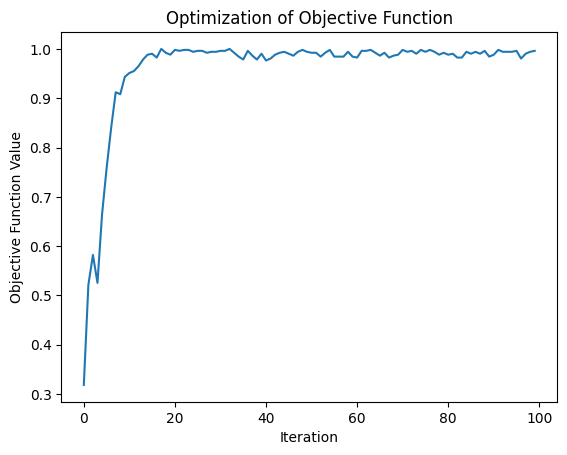

Optimized Parameters: [6.24929807 3.0875036  1.92854842 3.94870257]


In [100]:
# np.random.seed(42)
adj_matrix = np.array([
    [0, 1, 1, 1],
    [1, 0, 1, 0],
    [1, 1, 0, 0],
    [1, 0, 0, 0]
])

N = adj_matrix.shape[0]
n = int(np.ceil(np.log2(N)))  # Number of qubits in the address register
m = 1  # Number of qubits in the embedding register (adjust as needed)

gamma = 0.5
alpha = 0.1
delta_theta = 0.01
beta = 0.1
t = 1  # Time parameter for evolution

theta = np.random.rand(N) * 2 * np.pi  # Initialize theta randomly

# Check some stuff
check_adjacency_matrix_dimension(adj_matrix)
check_convergence_criterion(adj_matrix, beta)
ajd_matrix = extend_adjacency_matrix(adj_matrix)

optimized_theta, objective_values = optimize_parameters(theta, adj_matrix, beta, alpha, delta_theta, n, m, t)

# Plotting the objective function
plt.plot(objective_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Optimization of Objective Function')
plt.show()

print("Optimized Parameters:", optimized_theta)

## Evaluation

Now we need to know how well this embedding performs. This is measured using a QML algorithm with a simple encoder as a benchmark

### Simple encoder

In [ ]:
num_features = adj_matrix.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output="mpl", style="clifford", fold=20)

### Declaring some universally used stuff

In [ ]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)

optimizer = COBYLA(maxiter=100)

sampler = Sampler()

### Visualising Evaluation

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

### Training QML Algorithm

In [ ]:
def train_qml(encoder):
    vqc = VQC(
        sampler=sampler,
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        callback=callback_graph,
    )
    
    # clear objective value history
    objective_func_vals = []
    
    start = time.time()
    # TODO: Get features and labels
    vqc.fit(train_features, train_labels)
    elapsed = time.time() - start
    
    print(f"Training time: {round(elapsed)} seconds")

#### Simple encoder

In [ ]:
train_qml(feature_map)

#### Our encoder

In [ ]:
# TODO: Add our encoder
train_qml()